In [7]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from dataclasses import dataclass
from typing import List
from scipy import stats
import logging
import seaborn as sns

@dataclass
class AnalysisConfig:
    """Configuration for analysis parameters"""
    output_dir: str
    time_slots: List[int]
    # path_lengths: List[int]
    load_critical_route: bool
    support_weight: float
    utilization_weight: float
    top_k: int = 10
    fig_size: tuple = (15, 10)
    font_size: int = 11
    
    def __post_init__(self):
        assert np.isclose(self.support_weight + self.utilization_weight, 1.0), "Weights must sum to 1"

class PathAnalyzer:
    """Handles path analysis and critical route calculations"""
    
    @staticmethod
    def calculate_path_utilization(road_ids: list, road_utilization: pd.DataFrame) -> float:
        """Calculate average utilization for a path"""
        if isinstance(road_ids, str):
            try:
                road_ids = eval(road_ids)
            except:
                road_ids = [road_ids]
                
        path_utils = road_utilization[road_utilization['road_id'].isin(road_ids)]['utilization']
        return path_utils.mean() if not path_utils.empty else 0.0
    
    def calculate_critical_routes(
        self,
        freq_itemsets: pd.DataFrame,
        road_utilization: pd.DataFrame,
        support_weight: float = 0.7,
        utilization_weight: float = 0.3
    ) -> pd.DataFrame:
        """Calculate critical routes with composite scores"""
        analysis_df = freq_itemsets.copy()
        
        # Calculate support
        total_paths = 466
        analysis_df['support'] = analysis_df['freq'] / total_paths
        
        # Calculate utilization
        analysis_df['avg_utilization'] = analysis_df['items'].apply(
            lambda x: self.calculate_path_utilization(x, road_utilization)
        )
        
        # Normalize utilization
        min_util = analysis_df['avg_utilization'].min()
        max_util = analysis_df['avg_utilization'].max()
        analysis_df['normalized_utilization'] = (
            (analysis_df['avg_utilization'] - min_util) / (max_util - min_util)
            if max_util > min_util else 0
        )
        
        # Calculate composite score
        analysis_df['composite_score'] = (
            support_weight * analysis_df['support'] +
            utilization_weight * analysis_df['normalized_utilization']
        )
        
        # Add route_id
        analysis_df['route_id'] = range(1, len(analysis_df) + 1)
        
        return analysis_df.sort_values('composite_score', ascending=False).reset_index(drop=True)
    
class PathVisualizer:
    """Handles visualization tasks."""
    
    def __init__(self, config: AnalysisConfig):
        self.config = config
        self.output_dir = Path(config.output_dir)
        
    def visualize_critical_routes(self, critical_routes: pd.DataFrame, time_slot: int) -> None:
        """
        Visualize critical routes by plotting composite scores.
        """
        fig, ax = plt.subplots(figsize=self.config.fig_size)
        k_critical_path = self.config.top_k

        # Select top-k critical routes
        top_k_routes = critical_routes.head(k_critical_path)

        # Plot composite scores
        bars = ax.bar(top_k_routes['route_id'], top_k_routes['composite_score'], color='skyblue')

        # Customize plot
        ax.set_xlabel('Critical Route Index', fontsize=self.config.font_size)
        ax.set_ylabel('Composite Score', fontsize=self.config.font_size, color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        ax.set_xticks(top_k_routes['route_id'])
        ax.grid(True, linestyle='--', alpha=0.7)
        self._annotate_bars(bars, ax)

        # Save the figure
        plt.tight_layout()
        plt.savefig(self.output_dir / f'critical_routes_t{time_slot}.png', bbox_inches='tight')
        plt.close()
        
    def plot_specific_length_paths(
        self,
        df: pd.DataFrame,
        path_length: int,
        case: str,
        time_slot: int
    ) -> None:
        """
        Plot paths of a specific length with composite score (primary axis) and frequency (secondary axis).
        """
        fig, ax1 = plt.subplots(figsize=self.config.fig_size)

        # Filter paths of the given length
        specific_paths = df[df['items'].apply(len) == path_length].nlargest(
            self.config.top_k, 'composite_score'
        )
        
        if not specific_paths.empty:
            x_pos = np.arange(len(specific_paths))
            
            # Plot composite scores on the primary axis
            bars1 = ax1.bar(x_pos, specific_paths['composite_score'], color='skyblue', label='Composite Score')
            ax1.set_ylabel('Composite Score', fontsize=self.config.font_size, color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')

            # Create secondary axis for frequency
            ax2 = ax1.twinx()
            bars2 = ax2.plot(x_pos, specific_paths['freq'], color='green', marker='o', label='Frequency')
            ax2.set_ylabel('Frequency', fontsize=self.config.font_size, color='green')
            ax2.tick_params(axis='y', labelcolor='green')

            # Add x-axis labels
            ax1.set_xlabel('Route Index', fontsize=self.config.font_size)
            ax1.set_xticks(x_pos)
            ax1.set_xticklabels(specific_paths['route_id'], fontsize=self.config.font_size)

            # Add legends
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=self.config.font_size)

            # Annotate bars
            self._annotate_bars(bars1, ax1)

            ax1.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(
                self.output_dir / f'length_{path_length}_paths_{case}_t{time_slot}.png',
                bbox_inches='tight'
            )
        else:
            print(f"No paths of length {path_length} found.")
        plt.close()

    def plot_max_length_paths(
        self,
        df: pd.DataFrame,
        case: str,
        time_slot: int
    ) -> None:
        """
        Plot paths with maximum length with composite score (primary axis) and frequency (secondary axis).
        """
        fig, ax1 = plt.subplots(figsize=self.config.fig_size)

        # Filter paths with maximum length
        max_length = df['items'].apply(len).max()
        max_paths = df[df['items'].apply(len) == max_length].nlargest(
            self.config.top_k, 'composite_score'
        )
        
        if not max_paths.empty:
            x_pos = np.arange(len(max_paths))
            
            # Plot composite scores on the primary axis
            bars1 = ax1.bar(x_pos, max_paths['composite_score'], color='skyblue', label='Composite Score')
            ax1.set_ylabel('Composite Score', fontsize=self.config.font_size, color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')

            # Create secondary axis for frequency
            ax2 = ax1.twinx()
            bars2 = ax2.plot(x_pos, max_paths['freq'], color='green', marker='o', label='Frequency')
            ax2.set_ylabel('Frequency', fontsize=self.config.font_size, color='green')
            ax2.tick_params(axis='y', labelcolor='green')

            # Add x-axis labels
            ax1.set_xlabel('Route Index', fontsize=self.config.font_size)
            ax1.set_xticks(x_pos)
            ax1.set_xticklabels(max_paths['route_id'], fontsize=self.config.font_size)

            # Add legends
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=self.config.font_size)

            # Annotate bars
            self._annotate_bars(bars1, ax1)

            ax1.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(
                self.output_dir / f'max_length_paths_{case}_t{time_slot}.png',
                bbox_inches='tight'
            )
        else:
            print(f"No paths with maximum length ({max_length}) found.")
        plt.close()
    
    
    def plot_comparison(
        self,
        sim_df: pd.DataFrame,
        model_df: pd.DataFrame,
        time_slot: int
    ) -> None:
        """
        Compare better-performing paths between simulation and model data.
        """
        fig, ax1 = plt.subplots(figsize=self.config.fig_size)
        
        # Select top-k paths by composite score
        sim_top_k = sim_df.nlargest(self.config.top_k, 'composite_score')
        model_top_k = model_df.nlargest(self.config.top_k, 'composite_score')
        x_pos = np.arange(self.config.top_k)
        
        # Plot simulation composite scores with pattern and contrast color
        bars1 = ax1.bar(
            x_pos - 0.2, 
            sim_top_k['composite_score'], 
            0.4, 
            label='Baseline simulation data', 
            color='skyblue', 
            edgecolor='black', 
            hatch='//'
        )
        
        # Plot model composite scores with a different pattern and contrast color
        bars2 = ax1.bar(
            x_pos + 0.2, 
            model_top_k['composite_score'], 
            0.4, 
            label='Noise added simulation data', 
            color='orange', 
            edgecolor='black', 
            hatch='xx'
        )
        
        # Customize axes
        ax1.set_xlabel(f'Top-{self.config.top_k} routes', fontsize=self.config.font_size)
        ax1.set_ylabel('Composite Priority Score (CPS)', fontsize=self.config.font_size)
        ax1.tick_params(axis='y', labelsize=self.config.font_size)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([f"{i+1}" for i in range(self.config.top_k)], fontsize=self.config.font_size)
        
        # Add legends
        ax1.legend(loc='upper right', fontsize=self.config.font_size)
        
        # Annotate bars
        # self._annotate_bars(bars1, ax1)
        # self._annotate_bars(bars2, ax1)
        
        ax1.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(
            self.output_dir / f'comparison_better_paths_t{time_slot}.png',
            bbox_inches='tight'
        )
        plt.close()

    def _annotate_bars(self, bars, ax):
        """Annotate bar heights with their values."""
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                height, 
                f'{height:.2f}', 
                ha='center', 
                va='bottom', 
                fontsize=self.config.font_size - 2
            )

###########################################################################################
#use fontsize=self.config.font_size        
class CorrelationAnalyzer:
    """Handles correlation analysis between original and noisy data"""
    
    def __init__(self, config: AnalysisConfig, output_dir: str = 'correlation_plots'):
        self.config = config
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
    
    def calculate_correlations(
        self,
        original_df: pd.DataFrame,
        noisy_df: pd.DataFrame,
        columns_to_analyze: List[str] = None
    ) -> pd.DataFrame:
        """Calculate correlation metrics between original and noisy data"""
        # ['items','freq','support','avg_utilization','normalized_utilization','composite_score']

        if columns_to_analyze is None:
            columns_to_analyze =['avg_utilization','support','composite_score']
            
        correlation_results = []
        
        for col in columns_to_analyze:
            if col not in original_df.columns or col not in noisy_df.columns:
                logging.warning(f"Column {col} not found in both dataframes")
                continue
                
            # Pearson correlation
            pearson_corr, pearson_p = stats.pearsonr(original_df[col], noisy_df[col])
            
            # Spearman rank correlation
            spearman_corr, spearman_p = stats.spearmanr(original_df[col], noisy_df[col])
            
            # Root Mean Square Error (RMSE)
            rmse = np.sqrt(np.mean((original_df[col] - noisy_df[col])**2))
            
            # Mean Absolute Percentage Error (MAPE)
            mape = np.mean(np.abs((original_df[col] - noisy_df[col]) / original_df[col])) * 100
            
            correlation_results.append({
                'column': col,
                'pearson_correlation': pearson_corr,
                'pearson_p_value': pearson_p,
                'spearman_correlation': spearman_corr,
                'spearman_p_value': spearman_p,
                'rmse': rmse,
                'mape': mape
            })
        
        return pd.DataFrame(correlation_results)
    
    def plot_correlations(
        self,
        original_df: pd.DataFrame,
        noisy_df: pd.DataFrame,
        time_slot: int = None,
        road_id: int = None
    ) -> None:
        """Create correlation plots between original and noisy data"""
        # Filter data if time_slot or road_id is specified
        # if time_slot is not None:
        #     original_df = original_df[original_df['time'] == time_slot]
        #     noisy_df = noisy_df[noisy_df['time'] == time_slot]
        # if road_id is not None:
        #     original_df = original_df[original_df['road_id'] == road_id]
        #     noisy_df = noisy_df[noisy_df['road_id'] == road_id]
        
        columns_to_plot = ['support', 'avg_utilization','composite_score']
        fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(20, 10))
        
        for i, col in enumerate(columns_to_plot):
            if col not in original_df.columns or col not in noisy_df.columns:
                continue
                
            # Scatter plot
            sns.scatterplot(
                x=original_df[col],
                y=noisy_df[col],
                alpha=0.5,
                ax=axes[i]
            )
            
            # Add diagonal line (perfect correlation)
            min_val = min(original_df[col].min(), noisy_df[col].min())
            max_val = max(original_df[col].max(), noisy_df[col].max())
            axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
            
            # Calculate correlation coefficient
            corr = np.corrcoef(original_df[col], noisy_df[col])[0, 1]

            if col == 'support':
                axes[i].set_title(f'Support\nCorrelation: {corr:.3f}', fontsize=self.config.font_size + 2)
                axes[i].set_xlabel('Baseline data', fontsize=self.config.font_size)
                axes[i].set_ylabel('Noisy data', fontsize=self.config.font_size)
                axes[i].tick_params(axis='both', labelsize=self.config.font_size)

            elif col == 'avg_utilization':
                axes[i].set_title(f'Avg. Utilzation\nCorrelation: {corr:.3f}', fontsize=self.config.font_size + 2)
                axes[i].set_xlabel('Baseline data', fontsize=self.config.font_size)
                axes[i].set_ylabel('Noisy data', fontsize=self.config.font_size)
                axes[i].tick_params(axis='both', labelsize=self.config.font_size)

            elif col == 'composite_score':
                axes[i].set_title(f'CPS Correlation: {corr:.3f}', fontsize=self.config.font_size + 2)
                axes[i].set_xlabel('Baseline data', fontsize=self.config.font_size)
                axes[i].set_ylabel('Noisy data', fontsize=self.config.font_size)
                axes[i].tick_params(axis='both', labelsize=self.config.font_size)

            
        plt.tight_layout()
        
        # Save plot with appropriate filename
        filename = f'correlation_t{time_slot}'
        # if time_slot is not None:
        #     filename += f'_time_{time_slot}'
        # if road_id is not None:
        #     filename += f'_road_{road_id}'
        plt.savefig(self.output_dir / f'{filename}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    def plot_time_series_comparison(
        self,
        original_df: pd.DataFrame,
        noisy_df: pd.DataFrame,
        road_id: int,
        column: str = 'composite_score'
    ) -> None:
        """Plot time series comparison for a specific road"""
        ##['items','freq','support','avg_utilization','normalized_utilization','composite_score']
        # Filter data for the specified road
        orig_road = original_df[original_df['road_id'] == road_id].sort_values('time')
        noisy_road = noisy_df[noisy_df['road_id'] == road_id].sort_values('time')
        
        plt.figure(figsize=(15, 6))
        plt.plot(orig_road['time'], orig_road[column], label='Original', alpha=0.7)
        plt.plot(noisy_road['time'], noisy_road[column], label='Noisy', alpha=0.7)
        
        plt.title(f'{column.replace("_", " ").title()} Time Series - Road {road_id}')
        plt.xlabel('Time')
        plt.ylabel(column.replace("_", " ").title())
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.savefig(
            self.output_dir / f'time_series_{column}_road_{road_id}.png',
            dpi=300,
            bbox_inches='tight'
        )
        plt.close()
    
    def create_summary_report(
        self,
        correlation_df: pd.DataFrame,
        output_file: str = 'correlation_summary.txt'
    ) -> None:
        """Create a text summary of correlation analysis"""
        with open(self.output_dir / output_file, 'w') as f:
            f.write("Correlation Analysis Summary\n")
            f.write("===========================\n\n")
            
            for _, row in correlation_df.iterrows():
                f.write(f"Column: {row['column']}\n")
                f.write(f"  Pearson Correlation: {row['pearson_correlation']:.3f}")
                f.write(f" (p-value: {row['pearson_p_value']:.3e})\n")
                f.write(f"  Spearman Correlation: {row['spearman_correlation']:.3f}")
                f.write(f" (p-value: {row['spearman_p_value']:.3e})\n")
                f.write(f"  RMSE: {row['rmse']:.3f}\n")
                f.write(f"  MAPE: {row['mape']:.3f}%\n\n")

#############################################################################################
def analyze_correlations(config: AnalysisConfig, original_df: pd.DataFrame, noisy_df: pd.DataFrame, time_slot: int) -> None:
    """Main function to perform correlation analysis"""
    analyzer = CorrelationAnalyzer(config, output_dir='D:/Thesis/files_output_dir/output_comparison/sim_correlation_analysis')
    
    # Calculate overall correlations
    correlation_df = analyzer.calculate_correlations(original_df, noisy_df)
    
    # Create overall correlation plots
    analyzer.plot_correlations(original_df, noisy_df,time_slot)
    
    print('time:', time_slot)
    # Create time slot specific correlation plots
    # for time_slot_5 in sorted(original_df['time'].unique())[:5]:  # First 5 time slots
    #     analyzer.plot_correlations(original_df, noisy_df, time_slot=time_slot_5)
    
    # # # Create road specific time series plots
    # for road_id in sorted(original_df['road_id'].unique())[:5]:  # First 5 roads
    #     analyzer.plot_time_series_comparison(original_df, noisy_df, road_id)
    
    # Create summary report
    output_file = f'correlation_summary_t{time_slot}.txt'
    analyzer.create_summary_report(correlation_df, output_file)
    
    return correlation_df

def load_json_data(file_pattern: str) -> pd.DataFrame:
    """Load and process JSON files"""
    data = []
    for file_path in glob.glob(file_pattern):
        with open(file_path, 'r') as file:
            file_data = [json.loads(line) for line in file]
            data.extend(file_data)
    return pd.DataFrame(data)

def load_utilization_data(file_path: str) -> pd.DataFrame:
    """Load utilization data"""
    utilization_data = pd.read_csv(file_path)
    utilization_data = utilization_data[['time','road_id','utilization']]
    utilization_data.columns = ['time','road_id','utilization']

    return utilization_data

def load_road_history(output_dir: str, data_files) -> pd.DataFrame:
    # Create empty list to store dataframes
    dfs = []
    
    # Load each file and append to list
    for file_name in data_files:
        try:
            file_path = Path(output_dir) / file_name
            df = pd.read_csv(file_path)
            # Select only required columns
            columns = ['time', 'road_id', 'utilization', 'inv_utilization']
            dfs.append(df[columns])
            # logger.info(f"Successfully loaded {file_name}")
            print(f"Successfully loaded {file_name}")
        except Exception as e:
            # logger.error(f"Error loading {file_name}: {str(e)}")
            # raise
            print(f"Error loading {file_name}: {str(e)}")
    
    # Combine all dataframes
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        # logger.info(f"Combined {len(dfs)} dataframes with {len(combined_df)} total rows")
        print(f"Combined {len(dfs)} dataframes with {len(combined_df)} total rows")
        return combined_df
    else:
        # raise ValueError("No data files were successfully loaded")
        print("No data files were successfully loaded")

def time_slot_utilization(road_history, time_slot):
    time_slot_data = road_history[
        road_history['time'] == time_slot
    ]

    # Convert road_id to string and reset index
    result_df = time_slot_data[['road_id','utilization']].copy()
    result_df['road_id'] = result_df['road_id'].astype(str)
    
    return result_df.reset_index(drop=True)


def main(config):
    
    # Create output directory
    Path(config.output_dir).mkdir(parents=True, exist_ok=True)
    
    # Initialize components
    analyzer = PathAnalyzer()
    visualizer = PathVisualizer(config)
    

    # Process each time slot
    for time_slot in config.time_slots:
        print(f"\nProcessing time slot: {time_slot}")
        
        if config.load_critical_route == True:
            sim_critical_routes = pd.read_csv(f'{config.output_dir}/sim_critical_routes_simulation_t{time_slot}.csv')
            sim_critical_routes_noise = pd.read_csv(f'{config.output_dir}/sim_noise_critical_routes_model_t{time_slot}.csv')

        else:
            # Load utilization data
            sim_utilization = load_utilization_data('D:/Thesis/files_output_dir/SubNetwork Graph/output_files/sim_road_network_utilization_tune.csv')
            sim_utilization_noise = load_utilization_data('D:/Thesis/files_output_dir/SubNetwork Graph/output_files/sim_road_network_utilization_noise_tune.csv')

            sim_utilization_time = time_slot_utilization(sim_utilization, time_slot)
            sim_utilization_noise_time = time_slot_utilization(sim_utilization_noise, time_slot)
            # Process data
            sim_freq_items = pd.read_csv(f'C:/Users/mamun_pc/Dropbox/Thesis/data/simulation_data/frequent_path/frequent_path_simulation_t{time_slot}.csv')
            sim_freq_items_noise = pd.read_csv(f'C:/Users/mamun_pc/Dropbox/Thesis/data/simulation_data/frequent_path_noise/frequent_path_simulation_noise_t{time_slot}.csv')
            
            sim_critical_routes = analyzer.calculate_critical_routes(
                sim_freq_items, sim_utilization_time, 
                config.support_weight, config.utilization_weight
            )
            sim_critical_routes_noise = analyzer.calculate_critical_routes(
                sim_freq_items_noise, sim_utilization_noise_time,
                config.support_weight, config.utilization_weight
            )
            
            # Save results
            sim_critical_routes.to_csv(f'{config.output_dir}/sim_critical_routes_simulation_t{time_slot}.csv', index=False)
            sim_critical_routes_noise.to_csv(f'{config.output_dir}/sim_noise_critical_routes_model_t{time_slot}.csv', index=False)
        
        # Create visualizations
        visualizer.visualize_critical_routes(sim_critical_routes, time_slot)
        visualizer.visualize_critical_routes(sim_critical_routes_noise, time_slot)

        for case, data in [("simulation", sim_critical_routes), ("noise_data", sim_critical_routes_noise)]:
            # Specific length paths
            path_length = sorted(data['items'].apply(len).unique())[:5]
            for length in path_length:
                visualizer.plot_specific_length_paths(data, int(length), case, time_slot)
            
            # Max length paths
            visualizer.plot_max_length_paths(data, case, time_slot)
        
        # print("#"*20,"\nsize:", len(sim_critical_routes))
        # print("#"*20,"\nsize:", len(sim_critical_routes_noise))
        # Comparison visualizations
        visualizer.plot_comparison(sim_critical_routes, sim_critical_routes_noise, time_slot)
       
        print(f"Completed processing time slot {time_slot}")

        # # Perform correlation analysis
        correlation_results = analyze_correlations(config, sim_critical_routes, sim_critical_routes_noise, time_slot)
        print("\nCorrelation Analysis Summary:")
        print(correlation_results)
        correlation_results.to_csv('D:/Thesis/files_output_dir/output_comparison/sim_correlation_analysis/' + f'correlation_analysis_simulation_t{time_slot}.csv', index=False)

if __name__ == "__main__":
    # Configuration
    config = AnalysisConfig(
        output_dir="D:/Thesis/files_output_dir/output_comparison",
        time_slots=[48, 78, 108], # 48, 78, 108
        # path_lengths=[1, 2, 3, 4, 5],
        load_critical_route = True,
        support_weight=0.7,
        utilization_weight=0.3,
        top_k=10,
        fig_size=(10, 10),
        font_size=21
    )
    main(config)


Processing time slot: 48
Completed processing time slot 48
time: 48

Correlation Analysis Summary:
            column  pearson_correlation  pearson_p_value  \
0  avg_utilization             0.618701              0.0   
1          support             0.428826              0.0   
2  composite_score             0.999741              0.0   

   spearman_correlation  spearman_p_value      rmse       mape  
0              0.628908               0.0  0.024890   6.326051  
1              0.223642               0.0  0.029700  15.677713  
2              1.000000               0.0  0.054202  26.037026  

Processing time slot: 78
Completed processing time slot 78
time: 78

Correlation Analysis Summary:
            column  pearson_correlation  pearson_p_value  \
0  avg_utilization             0.551406              0.0   
1          support             0.613781              0.0   
2  composite_score             0.999614              0.0   

   spearman_correlation  spearman_p_value      rmse       

## Result Interpretation time slot: 48
1. freq and support
Pearson Correlation: 0.030562
Very low correlation, indicating almost no linear relationship.
Spearman Correlation: 0.020074
Very low monotonic relationship as well.
RMSE: 18.03 (for freq) and 0.000002 (for support):
freq has a high RMSE, suggesting a larger error in predictions.
support has an extremely low RMSE, indicating predictions closely match actual values.
MAPE: Both have around 19.46%, indicating moderate predictive accuracy.
2. avg_utilization, normalized_utilization, and composite_score
Pearson Correlation: 0.994792
Very high positive correlation, indicating a near-perfect linear relationship.
Spearman Correlation: 1.000000
Perfect monotonic relationship, meaning the values move together consistently.
RMSE:
avg_utilization: 0.067141 (very low error).
normalized_utilization: 0.246331 (moderate error).
composite_score: 0.073899 (very low error).
MAPE:
avg_utilization: 11.10% (better accuracy than the other two).
normalized_utilization and composite_score: 61.26% (poor accuracy).

## Summery
Low Correlation for freq and support:

Both metrics have minimal linear and monotonic relationships, as shown by low Pearson and Spearman correlations. This indicates that the noisy/simulated data does not preserve these metrics well.
High Correlation for avg_utilization, normalized_utilization, and composite_score:

These metrics have extremely high correlations, suggesting that the noisy/simulated data effectively preserves their relationships with the original data.
RMSE and MAPE Highlights:

avg_utilization shows the best accuracy (low RMSE and MAPE).
freq and support are moderately preserved with reasonable MAPE (~19%), but freq has a high RMSE indicating potential variability in predictions.
normalized_utilization and composite_score have high MAPE (~61%), indicating significant percentage errors, even though their correlations are perfect.

In [ ]:
df = pd.read_csv(f'{"D:/Thesis/files_output_dir/output_comparison"}/sim_critical_routes_simulation_t{48}.csv')
specific_paths = df[df['items'].apply(len) == 1].nlargest(
            10, 'composite_score'
        )
specific_paths.head()

In [ ]:
# df.head()
print(sorted(df['items'].apply(len).unique())[:5])

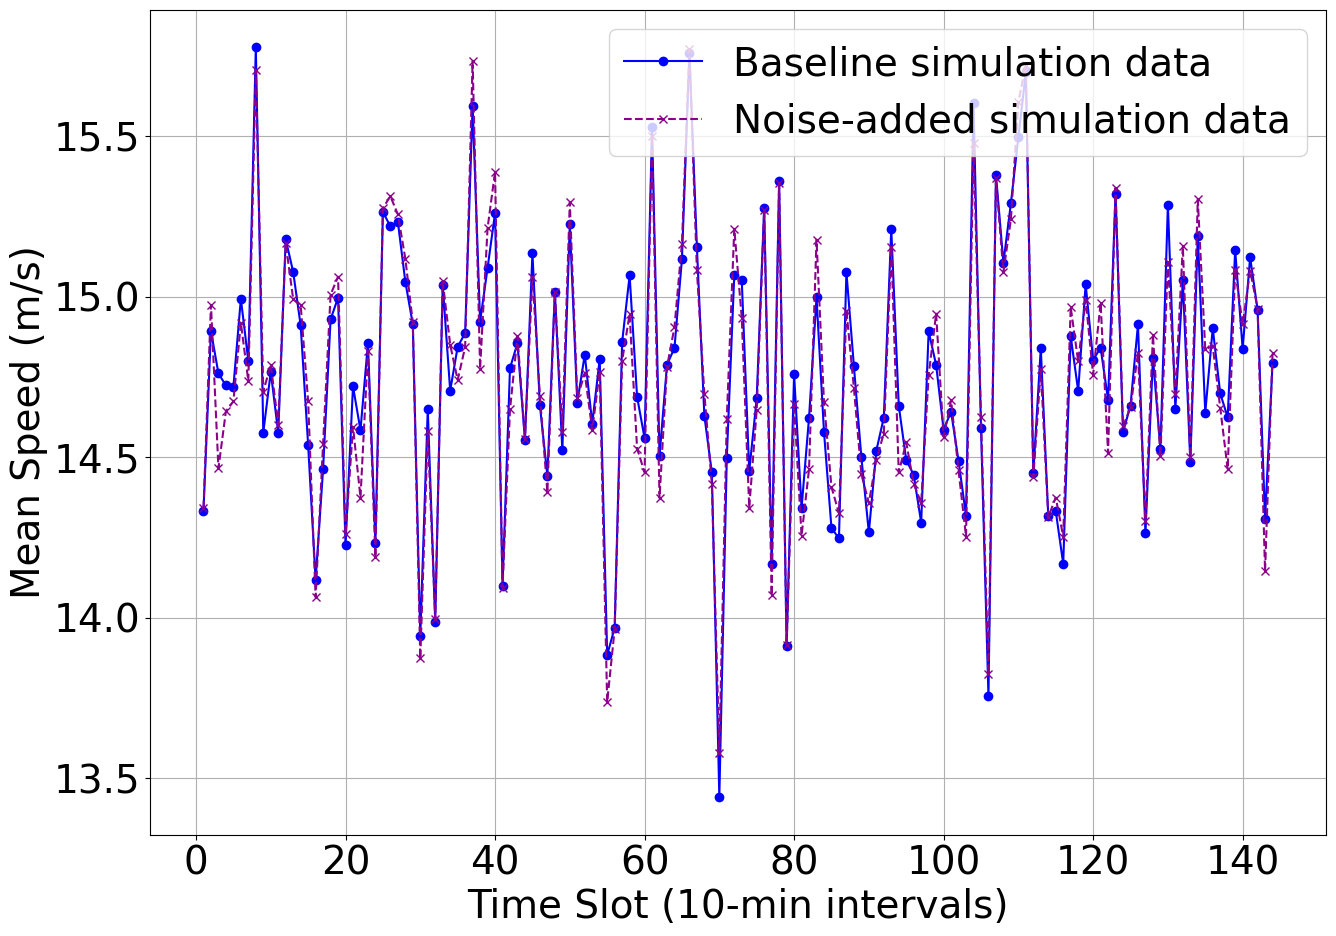

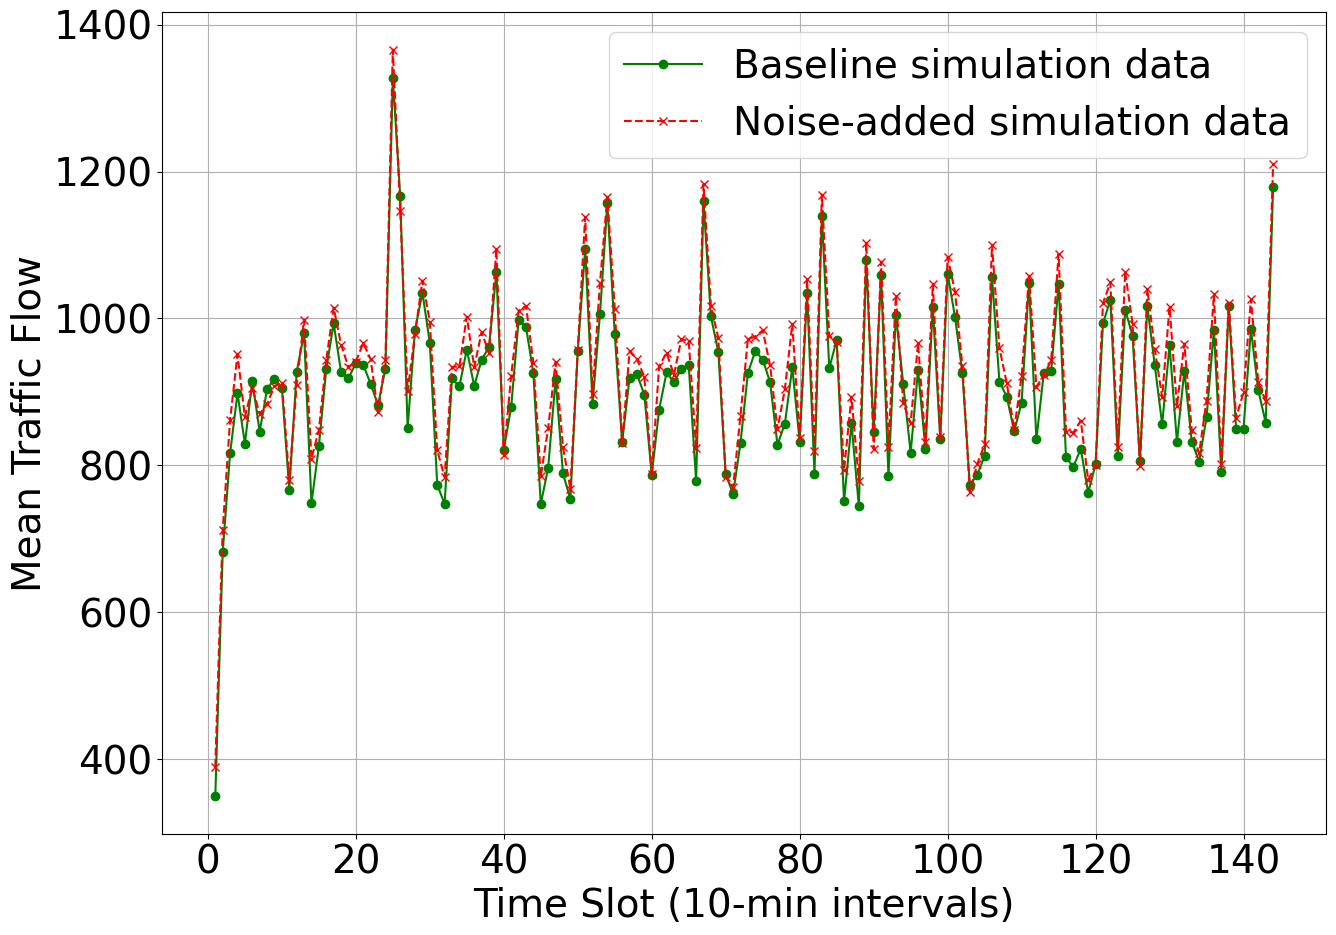

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrames (Assuming df1 and df2 already exist with similar columns)
utilization_sim_path= 'D:/Thesis/files_output_dir/SubNetwork Graph/output_files/sim_road_network_utilization_tune.csv'
df1 = pd.read_csv(utilization_sim_path)

## laplace 
# noise = np.random.laplace(loc=0, scale=1, size=df1.shape[0])
utilization_sim_noise_path= 'D:/Thesis/files_output_dir/SubNetwork Graph/output_files/sim_road_network_utilization_noise_tune.csv'
df2 = pd.read_csv(utilization_sim_noise_path)
# df2['volume'] = df1['volume'] + noise


# Step 1: Aggregate mean speed and volume for each time slot across all road_ids
def calculate_mean_metrics(df, metric):
    """
    Calculate mean of a specific metric (e.g., 'avg_speed' or 'volume') for each time slot.
    """
    # Group by 'time' and calculate the mean of the specified metric
    # mean_metric = df.groupby('time')[metric].mean().reset_index()
    # mean_metric.rename(columns={metric: f'mean_{metric}'}, inplace=True)
    if metric == 'volume':
        # Multiply the 'volume' column by 10 before calculating the mean
        df_copy = df.copy()  # Create a copy to avoid modifying the original DataFrame
        df_copy['volume'] = df_copy['volume'] # Apply multiplication to the copy
        mean_metric = df_copy.groupby('time')['volume'].mean().reset_index()
        mean_metric.rename(columns={'volume': 'mean_volume'}, inplace=True)


    else:
        # Calculate the mean for other metrics without modification
        mean_metric = df.groupby('time')[metric].mean().reset_index()
        mean_metric.rename(columns={metric: f'mean_{metric}'}, inplace=True)

    return mean_metric

# Calculate mean speeds and volumes for df1 and df2
mean_speed_df1 = calculate_mean_metrics(df1, 'avg_speed')
mean_volume_df1 = calculate_mean_metrics(df1, 'volume')

mean_speed_df2 = calculate_mean_metrics(df2, 'avg_speed')
mean_volume_df2 = calculate_mean_metrics(df2, 'volume')

# Set global font size to 28
plt.rcParams.update({'font.size': 28})

# Step 2: Plot Mean Speed
plt.figure(figsize=(14, 10))

# Plot df1 mean speed
plt.plot(mean_speed_df1['time'], mean_speed_df1['mean_avg_speed'], label='Baseline simulation data', color='blue', marker='o', linestyle='-')

# Plot df2 mean speed
plt.plot(mean_speed_df2['time'], mean_speed_df2['mean_avg_speed'], label='Noise-added simulation data', color='darkmagenta', marker='x', linestyle='--')

# Add labels, title, and legend
# plt.title('Mean Speed Across All Roads Over Time', fontsize=28)
plt.xlabel('Time Slot (10-min intervals)', fontsize=28)
plt.ylabel('Mean Speed (m/s)', fontsize=28)
plt.legend(loc='upper right', fontsize=28)
plt.grid(True)

# Increase tick label font size
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

# Save the plot as high-resolution image with 300 DPI
plt.tight_layout()
plt.savefig('D:/Thesis/files_output_dir/SubNetwork Graph/noise_speed_dist.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 3: Plot Mean Volume
plt.figure(figsize=(14, 10))

# Plot df1 mean volume
plt.plot(mean_volume_df1['time'], mean_volume_df1['mean_volume'], label='Baseline simulation data', color='green', marker='o', linestyle='-')

# Plot df2 mean volume
plt.plot(mean_volume_df2['time'], mean_volume_df2['mean_volume'], label='Noise-added simulation data', color='red', marker='x', linestyle='--')

# Add labels, title, and legend
# plt.title('Mean Volume Across All Roads Over Time', fontsize=28)
plt.xlabel('Time Slot (10-min intervals)', fontsize=28)
plt.ylabel('Mean Traffic Flow', fontsize=28)
plt.legend(loc='upper right', fontsize=28)
plt.grid(True)

# Increase tick label font size
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

# Save the plot as high-resolution image with 300 DPI
plt.tight_layout()
plt.savefig('D:/Thesis/files_output_dir/SubNetwork Graph/noise_flow_dist.png', dpi=300, bbox_inches='tight')
plt.show()

## back-up code

## Draft

In [ ]:
import pandas as pd


In [ ]:
import pandas as pd

utilization_sim_path= 'D:/Thesis/files_output_dir/SubNetwork Graph/output_files/sim_road_network_utilization_tune.csv'
df1 = pd.read_csv(utilization_sim_path)
df1.head()
print(df1.head(10).to_markdown(index=False))

utilization_sim_noise_path= 'D:/Thesis/files_output_dir/SubNetwork Graph/output_files/sim_road_network_utilization_noise_tune.csv'
df2 = pd.read_csv(utilization_sim_noise_path)
# df2.columns
print(df2.head(10).to_markdown(index=False))
df2.head()

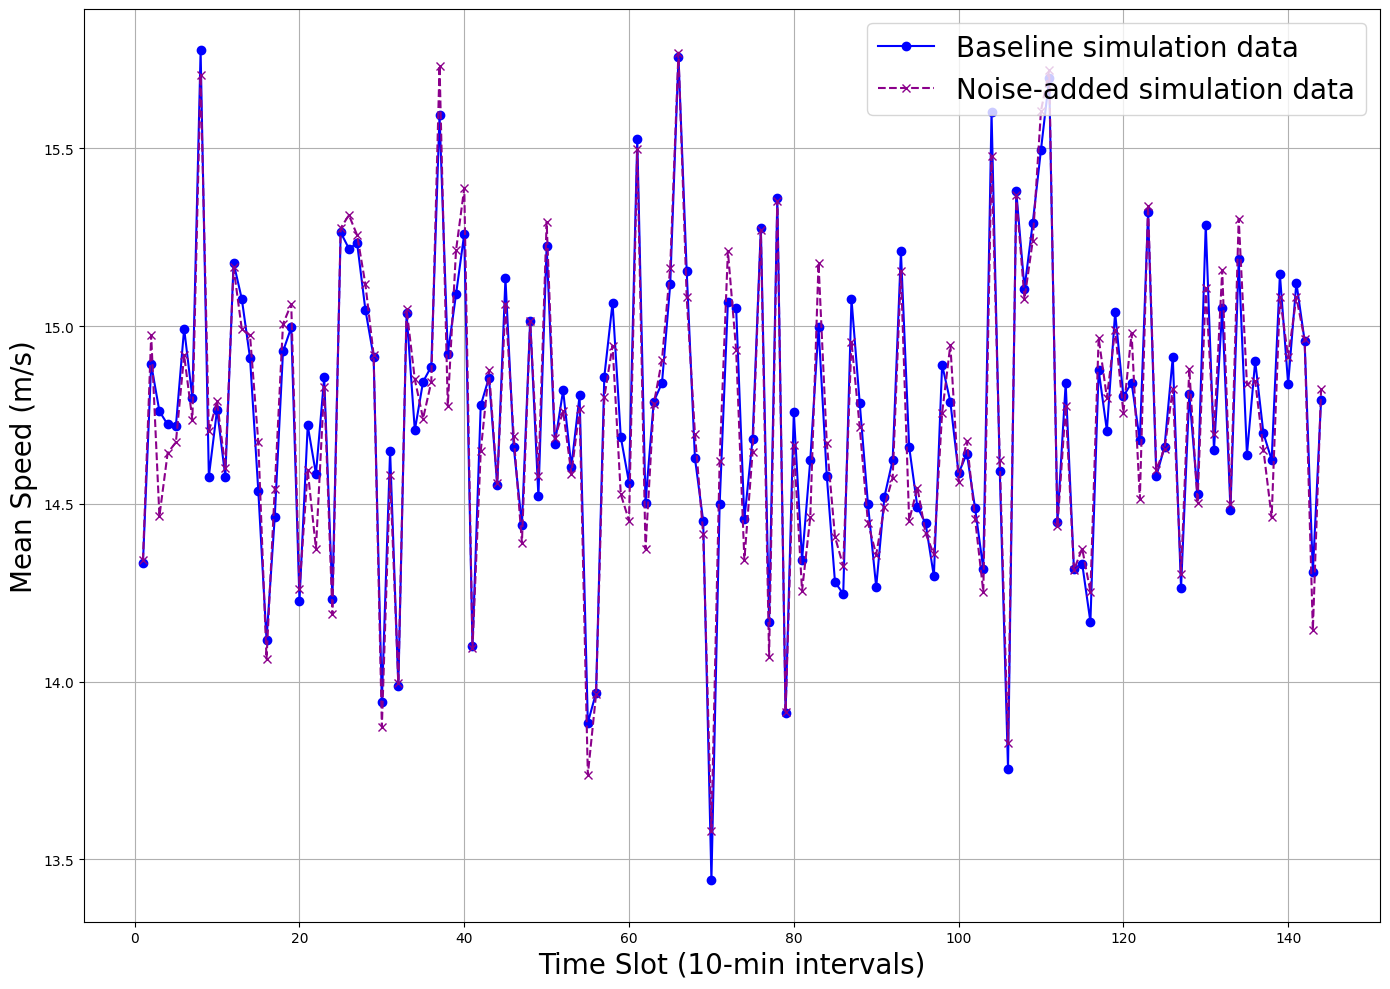

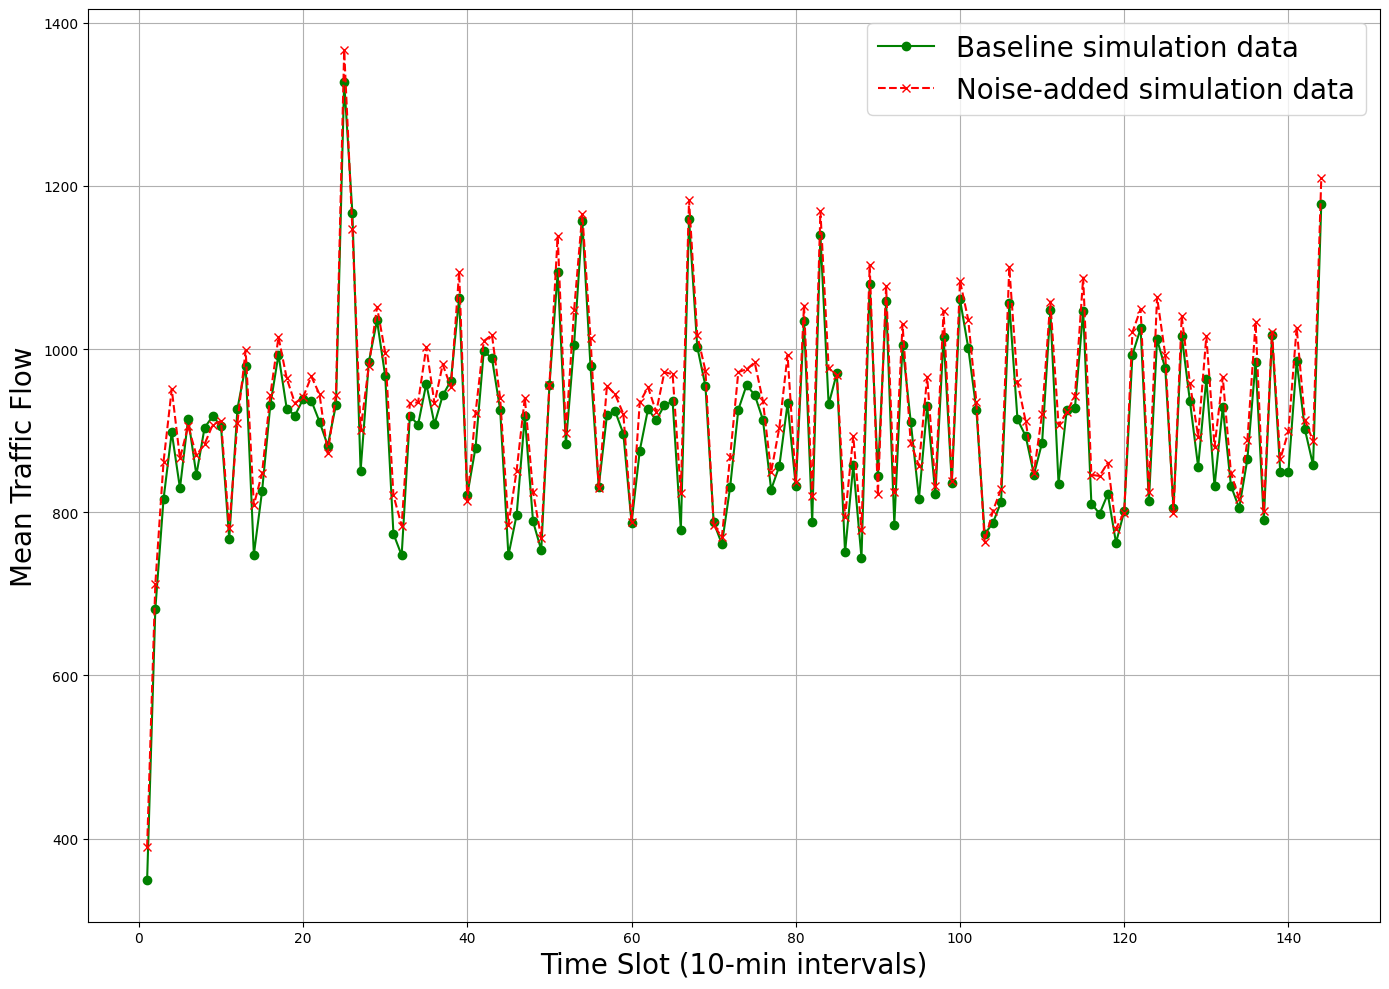

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrames (Assuming df1 and df2 already exist with similar columns)
utilization_sim_path= 'D:/Thesis/files_output_dir/SubNetwork Graph/output_files/sim_road_network_utilization_tune.csv'
df1 = pd.read_csv(utilization_sim_path)

## laplace 
# noise = np.random.laplace(loc=0, scale=1, size=df1.shape[0])
utilization_sim_noise_path= 'D:/Thesis/files_output_dir/SubNetwork Graph/output_files/sim_road_network_utilization_noise_tune.csv'
df2 = pd.read_csv(utilization_sim_noise_path)
# df2['volume'] = df1['volume'] + noise


# Step 1: Aggregate mean speed and volume for each time slot across all road_ids
def calculate_mean_metrics(df, metric):
    """
    Calculate mean of a specific metric (e.g., 'avg_speed' or 'volume') for each time slot.
    """
    # Group by 'time' and calculate the mean of the specified metric
    # mean_metric = df.groupby('time')[metric].mean().reset_index()
    # mean_metric.rename(columns={metric: f'mean_{metric}'}, inplace=True)
    if metric == 'volume':
        # Multiply the 'volume' column by 10 before calculating the mean
        df_copy = df.copy()  # Create a copy to avoid modifying the original DataFrame
        df_copy['volume'] = df_copy['volume'] # Apply multiplication to the copy
        mean_metric = df_copy.groupby('time')['volume'].mean().reset_index()
        mean_metric.rename(columns={'volume': 'mean_volume'}, inplace=True)


    else:
        # Calculate the mean for other metrics without modification
        mean_metric = df.groupby('time')[metric].mean().reset_index()
        mean_metric.rename(columns={metric: f'mean_{metric}'}, inplace=True)

    return mean_metric

# Calculate mean speeds and volumes for df1 and df2
mean_speed_df1 = calculate_mean_metrics(df1, 'avg_speed')
mean_volume_df1 = calculate_mean_metrics(df1, 'volume')

mean_speed_df2 = calculate_mean_metrics(df2, 'avg_speed')
mean_volume_df2 = calculate_mean_metrics(df2, 'volume')

# Step 2: Plot Mean Speed
plt.figure(figsize=(14, 10))

# Plot df1 mean speed
plt.plot(mean_speed_df1['time'], mean_speed_df1['mean_avg_speed'], label='Baseline simulation data', color='blue', marker='o', linestyle='-')

# Plot df2 mean speed
plt.plot(mean_speed_df2['time'], mean_speed_df2['mean_avg_speed'], label='Noise-added simulation data', color='darkmagenta', marker='x', linestyle='--')

# Add labels, title, and legend
# plt.title('Mean Speed Across All Roads Over Time', fontsize=14)
plt.xlabel('Time Slot (10-min intervals)', fontsize=20)
plt.ylabel('Mean Speed (m/s)', fontsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Step 3: Plot Mean Volume
plt.figure(figsize=(14, 10))

# Plot df1 mean volume
plt.plot(mean_volume_df1['time'], mean_volume_df1['mean_volume'], label='Baseline simulation data', color='green', marker='o', linestyle='-')

# Plot df2 mean volume
plt.plot(mean_volume_df2['time'], mean_volume_df2['mean_volume'], label='Noise-added simulation data', color='red', marker='x', linestyle='--')

# Add labels, title, and legend
# plt.title('Mean Volume Across All Roads Over Time', fontsize=14)
plt.xlabel('Time Slot (10-min intervals)', fontsize=20)
plt.ylabel('Mean Traffic Flow', fontsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()